In [97]:
%pylab inline
from collections import defaultdict, OrderedDict
import warnings
import gffutils
import pybedtools
from riboraptor.interval import Interval
from riboraptor.fasta import FastaReader
from tqdm import tqdm
import pandas as pd
import copy
import os
import re
from gffutils.pybedtools_integration import tsses
from copy import deepcopy
from collections import OrderedDict, Callable, Counter
import errno
import seaborn as sns
sns.set_context('paper', font_scale=2)
sns.set_style('white')

def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            
class DefaultOrderedDict(OrderedDict):
    # Source: http://stackoverflow.com/a/6190500/562769
    def __init__(self, default_factory=None, *a, **kw):
        if (default_factory is not None and
           not isinstance(default_factory, Callable)):
            raise TypeError('first argument must be callable')
        OrderedDict.__init__(self, *a, **kw)
        self.default_factory = default_factory

    def __getitem__(self, key):
        try:
            return OrderedDict.__getitem__(self, key)
        except KeyError:
            return self.__missing__(key)

    def __missing__(self, key):
        if self.default_factory is None:
            raise KeyError(key)
        self[key] = value = self.default_factory()
        return value

    def __reduce__(self):
        if self.default_factory is None:
            args = tuple()
        else:
            args = self.default_factory,
        return type(self), args, None, None, self.items()

    def copy(self):
        return self.__copy__()

    def __copy__(self):
        return type(self)(self.default_factory, self)

    def __deepcopy__(self, memo):
        import copy
        return type(self)(self.default_factory,
                          copy.deepcopy(self.items()))

    def __repr__(self):
        return 'OrderedDefaultDict(%s, %s)' % (self.default_factory,
                                               OrderedDict.__repr__(self))


Populating the interactive namespace from numpy and matplotlib


/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
gtf = '/home/cmb-panasas2/skchoudh/genomes/hg38/annotation/gencode.v25.annotation.gtf'
gtf_db = '/home/cmb-panasas2/skchoudh/genomes/hg38/annotation/gencode.v25.annotation.gtf.db'
chrsizes = '/home/cmb-panasas2/skchoudh/genomes/hg38/fasta/hg38.chrom.sizes'
fasta = '/home/cmb-panasas2/skchoudh/genomes/hg38/fasta/hg38.fa'

In [3]:
def create_gene_dict(db):
    '''
    Store each feature line db.all_features() as a dict of dicts
    '''
    gene_dict = DefaultOrderedDict(lambda: DefaultOrderedDict(lambda: DefaultOrderedDict(list)))
    for line_no, feature in enumerate(db.all_features()):
        gene_ids = feature.attributes['gene_id']
        feature_type = feature.featuretype
        if feature_type == 'gene':
            if len(gene_ids)!=1:
                logging.warning('Found multiple gene_ids on line {} in gtf'.format(line_no))
                break
            else:
                gene_id = gene_ids[0]
                gene_dict[gene_id]['gene'] = feature
        else:
            transcript_ids = feature.attributes['transcript_id']

            for gene_id in gene_ids:
                for transcript_id in transcript_ids:
                    gene_dict[gene_id][transcript_id][feature_type].append(feature)
    return gene_dict

In [4]:
db = gffutils.FeatureDB(gtf_db, keep_order=True)
gene_dict = create_gene_dict(db)


In [5]:
for x in db.featuretypes():
    print(x)

CDS
Selenocysteine
UTR
exon
gene
start_codon
stop_codon
transcript


In [6]:
fasta_reader = FastaReader(fasta)

In [7]:
def get_UTR_regions(utrs, cds):
    if len(cds)==0:
        return [], []
    utr5_regions = []
    utr3_regions = []    
    cds_sorted = sorted(list(cds), key=lambda x: x.start)
    first_cds = cds_sorted[0]
    last_cds = cds_sorted[-1]
    for orig_utr in utrs:
        utr = deepcopy(orig_utr)
        ## Push all cds at once
        ## Sort later to remove duplicates
        strand = utr.strand
        if utr.start < first_cds.start:
            if utr.stop >= first_cds.start:
                utr.stop = first_cds.start - 1
            if strand == '+':
                utr5_regions.append(utr)
            else:
                utr3_regions.append(utr)
        elif utr.stop > last_cds.stop:
            if utr.start <= last_cds.stop:
                utr.start = last_cds.stop + 1
            if strand == '+':
                utr3_regions.append(utr)
            else:
                utr5_regions.append(utr)
       
    return utr5_regions, utr3_regions

def get_gene_list(gene_dict):
    return list(set(gene_dict.keys()))

# What do we do now?

Our aim to to extract all the dORFs and uORFs. We start with a very general definition of (u|d)ORF:
Given coordinates of the UTR, we will look for star_codons

start_codons = ['ATG', 'AAG', 'ACG', 'ATC', 'GTG', 'AGG', 'ATA', 'ATT', 'CTG', 'TTG']

stop_codons = ['TAG, 'TAA', 'TGA']

Le's deal with uORFs first.


In [8]:
START_CODONS = ['ATG', 'AAG', 'ACG', 'ATC', 'GTG', 'AGG', 'ATA', 'ATT', 'CTG', 'TTG']

STOP_CODONS = ['TAG', 'TAA', 'TGA']


In [9]:
gene_wise_CCDS_dict = DefaultOrderedDict(list)

for line_no, feature in enumerate(db.all_features()):
    gene_ids = feature.attributes['gene_id']    
    feature_type = feature.featuretype
    try:
        tags = feature.attributes['tag']
        if feature_type != 'UTR':
            continue
        
        else:
            assert len(gene_ids) == 1
            gene_id = gene_ids[0]
            transcript_ids = feature.attributes['transcript_id']
            assert len(transcript_ids) == 1
            transcript_id = transcript_ids[0]

            feature.attributes['gene_id'] = '{}_{}'.format(gene_id, transcript_id)
            gene_wise_CCDS_dict[gene_id].append(feature)
    except:
        continue

In [90]:
tx_types_counts = defaultdict(list)
for line_no, feature in enumerate(db.all_features()):
    gene_ids = feature.attributes['gene_id']    
    feature_type = feature.featuretype
    try:
        if feature_type != 'transcript':
            continue
        else:
            
            assert len(gene_ids) == 1
            gene_id = gene_ids[0]
            transcript_ids = feature.attributes['transcript_id']
            assert len(transcript_ids) == 1
            transcript_id = transcript_ids[0]

            transcript_type = feature.attributes['transcript_type']
            assert len(transcript_type) == 1
            transcript_type = transcript_type[0]
            tx_types_counts[transcript_type].append(transcript_id)
            
            
    except:
        continue

In [93]:
s = 0
for key, l in tx_types_counts.items():
    print(key, len(set(l)))
    s+=len(set(l))
s

processed_transcript 27754
transcribed_unprocessed_pseudogene 739
unprocessed_pseudogene 2664
miRNA 1871
lincRNA 13255
protein_coding 80087
processed_pseudogene 10277
antisense 11036
snRNA 1900
transcribed_processed_pseudogene 450
retained_intron 26955
nonsense_mediated_decay 13769
sense_intronic 966
misc_RNA 2227
TEC 1135
pseudogene 42
unitary_pseudogene 155
non_stop_decay 83
snoRNA 956
scaRNA 49
rRNA 544
3prime_overlapping_ncRNA 34
polymorphic_pseudogene 68
transcribed_unitary_pseudogene 60
sense_overlapping 309
IG_V_pseudogene 193
bidirectional_promoter_lncRNA 11
scRNA 1
IG_V_gene 145
IG_C_gene 17
IG_J_gene 18
sRNA 5
ribozyme 8
vaultRNA 1
non_coding 3
TR_C_gene 6
TR_J_gene 79
TR_V_gene 108
TR_V_pseudogene 30
TR_D_gene 4
IG_C_pseudogene 9
macro_lncRNA 1
TR_J_pseudogene 4
IG_J_pseudogene 3
IG_D_gene 37
IG_pseudogene 1
Mt_tRNA 22
Mt_rRNA 2


198093

In [88]:
np.sum(list(tx_types_counts.values()))

198093

# CCDS exons

In [95]:
ccds_exons = defaultdict(list)
ccds_exons_lengths = []
for line_no, feature in enumerate(db.all_features()):
    gene_ids = feature.attributes['gene_id']    
    feature_type = feature.featuretype
    try:
        tags = feature.attributes['tag']
        if 'CCDS' not in tags:
            # Anything that is not CCDS is not interesting
            continue
        if feature_type != 'exon':
            continue
        else:
            assert len(gene_ids) == 1
            gene_id = gene_ids[0]
            transcript_ids = feature.attributes['transcript_id']
            assert len(transcript_ids) == 1
            transcript_id = transcript_ids[0]
            ccds_exons_lengths.append(feature.end-feature.start)
            ccds_exons[gene_id].append(feature)
    except:
        continue
        
    

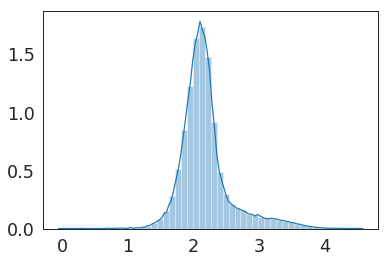

In [99]:
sns.distplot(np.log10(ccds_exons_lengths))

In [10]:
UTR_5 = []
UTR_3 = []

In [11]:
for gene_id in tqdm(get_gene_list(gene_dict)):   
    utr5_regions, utr3_regions = [], []
    cds_regions = []
    utr_regions = []
    for feature in gene_dict[gene_id].keys():
        if feature == 'gene':
            continue
        cds = list(gene_dict[gene_id][feature]['CDS'])
        utrs = list(gene_dict[gene_id][feature]['UTR'])

        cds = sorted(list(cds), key=lambda x: x.start)
        utrs  = sorted(list(utrs), key=lambda x: x.start)
        
        cds_regions += cds
        utr_regions += utrs

    cds_regions = sorted(list(cds_regions), key=lambda x: x.start)
    utr_regions = sorted(list(utr_regions), key=lambda x: x.start)
    
    utr5_regions, utr3_regions = get_UTR_regions(utr_regions, cds_regions)
    
    UTR_5 += utr5_regions
    UTR_3 += utr3_regions
    
    

100%|██████████| 58037/58037 [00:32<00:00, 1778.04it/s]


In [28]:
len(UTR_5)

103583

In [12]:
to_write = 'transcript_id\tgene_id\tgene_type\tchrom\tstart\tend\tstrand\texon_number\ttags\tis_CCDS\tuORF_type\n'
for utr5 in UTR_5:
    transcript_id = utr5.attributes['transcript_id']
    assert len(transcript_id) == 1
    transcript_id = transcript_id[0]
    gene_id = utr5.attributes['gene_id']
    assert len(gene_id) == 1
    gene_id = gene_id[0]
    
    gene_type = utr5.attributes['gene_type']
    assert len(gene_type) == 1
    gene_type = gene_type[0]

    exon_number = utr5.attributes['exon_number']
    assert len(exon_number) == 1
    exon_number = exon_number[0]
    
    try:
        tags = utr5.attributes['tag']
    except:
        tags = []
    start = utr5.start
    end = utr5.end
    chrom = utr5.chrom
    strand = utr5.strand
    uorf_type = ''
    for tag in tags:
        if 'uORF' in tag:
            uorf_type = tag
            break
    
    if 'CCDS' in tags:
        is_ccds=1
    else:
        is_ccds=0
    to_write += '{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\t{7}\t{8}\t{9}\t{10}'.format(transcript_id, gene_id, gene_type,
                                                       chrom, start, end, 
                                                       strand, exon_number, (',').join(sorted(tags)), is_ccds, uorf_type)
    to_write += '\n'
    

In [13]:
"uORF" in "overlapping_uORF"

True

In [14]:
with open('/staging/as/skchoudh/hg38_UTR5.tsv', 'w') as f:
    f.write(to_write)

In [64]:
utr5_df = pd.read_table('/staging/as/skchoudh/hg38_UTR5.tsv')

In [65]:
utr5_df = utr5_df.sort_values(by=['transcript_id', 'gene_id', 'chrom', 'start', 'end', 'strand', 'exon_number']).reset_index(drop=True)

In [66]:
utr5_df.head()

,transcript_id,gene_id,gene_type,chrom,start,end,strand,exon_number,tags,is_CCDS,uORF_type
0,ENST00000000233.9,ENSG00000004059.10,protein_coding,chr7,127588345,127588498,+,1,"CCDS,appris_principal_1,basic",1,NaN
1,ENST00000000412.7,ENSG00000003056.7,protein_coding,chr12,8946405,8946405,-,2,"CCDS,appris_principal_1,basic",1,NaN
2,ENST00000000412.7,ENSG00000003056.7,protein_coding,chr12,8949488,8949955,-,1,"CCDS,appris_principal_1,basic",1,NaN
3,ENST00000000442.10,ENSG00000173153.13,protein_coding,chr11,64305578,64305736,+,1,"CCDS,NAGNAG_splice_site,appris_principal_3,basic",1,NaN
4,ENST00000000442.10,ENSG00000173153.13,protein_coding,chr11,64307168,64307179,+,2,"CCDS,NAGNAG_splice_site,appris_principal_3,basic",1,NaN


In [67]:
utr5_df.uORF_type.value_counts()

upstream_uORF       238
overlapping_uORF     59
Name: uORF_type, dtype: int64

In [68]:
utr5_df.head()

,transcript_id,gene_id,gene_type,chrom,start,end,strand,exon_number,tags,is_CCDS,uORF_type
0,ENST00000000233.9,ENSG00000004059.10,protein_coding,chr7,127588345,127588498,+,1,"CCDS,appris_principal_1,basic",1,NaN
1,ENST00000000412.7,ENSG00000003056.7,protein_coding,chr12,8946405,8946405,-,2,"CCDS,appris_principal_1,basic",1,NaN
2,ENST00000000412.7,ENSG00000003056.7,protein_coding,chr12,8949488,8949955,-,1,"CCDS,appris_principal_1,basic",1,NaN
3,ENST00000000442.10,ENSG00000173153.13,protein_coding,chr11,64305578,64305736,+,1,"CCDS,NAGNAG_splice_site,appris_principal_3,basic",1,NaN
4,ENST00000000442.10,ENSG00000173153.13,protein_coding,chr11,64307168,64307179,+,2,"CCDS,NAGNAG_splice_site,appris_principal_3,basic",1,NaN


In [80]:
len(utr5_df.transcript_id.unique())

65246

# Selection strategy:
1. Most upstream AUG is a definitive ORF. The first such ORF would also have the closest 
stop codon

The above table is 5'UTR, so the start codon is given by "end+1" for positive strand and "end-1" for negative strand.
Remember everything is 1-based. To verify, we fetch the sequence of these coordinates and see if they are indeed ATG.
for negative coordinates we need to reverse complement.



In [120]:
def find_matches(string, list_of_codons):
    """Returns 0-based positions"""
    #matches = re.finditer(re.compile('|'.join(list_of_codons)) , string)
    matches = re.finditer(r"(?=({}))".format('|'.join(list_of_codons)) , string)

    matching_positions = OrderedDict()
    for match in matches:
        matching_positions[match.start(0)] = match.group(1)
    matching_positions_codonwise = defaultdict(list)
    for index, codon in matching_positions.items():
        matching_positions_codonwise[codon].append(index)
    return matching_positions, matching_positions_codonwise


def find_candidate_orfs(start_codon_matches, stop_codon_matches):
    start_codon_matches_framewise = OrderedDict()
    for frame in [0,1,2]:
        start_codon_matches_framewise[frame] = list(filter(lambda x: x[0]%3 ==frame, start_codon_matches.items()))
    stop_codon_matches_framewise = OrderedDict()
    
    for frame in [0,1,2]:
        stop_codon_matches_framewise[frame] = list(filter(lambda x: x[0]%3 ==frame, stop_codon_matches.items()))
        
    candidate_orfs = OrderedDict()
    candidate_orfs['starts'] = []
    candidate_orfs['stops'] = []
    candidate_orfs['start-stop'] = []

    for frame in start_codon_matches_framewise.keys() & start_codon_matches_framewise.keys():
        start_list = start_codon_matches_framewise[frame]
        stop_list = stop_codon_matches_framewise[frame]

        # For each start_codon, find the first stop codon it would encounter
        # We assume that once a stop codon is encountered, it would not be 
        # read through, at least not in the uORF

        for start_index, start_codon in start_list:
            for stop_index, stop_codon in stop_list:
                # Assume sequence coordinates, so strand etc already 
                # have been accounted for
                if stop_index-start_index>0:
                    candidate_orfs['starts'].append((start_index, start_codon, frame, stop_index-start_index))
                    candidate_orfs['stops'].append((stop_index, start_codon, frame, stop_index-start_index))
                    candidate_orfs['start-stop'].append((start_index, stop_index, start_codon, stop_codon, stop_index-start_index))
                    #break
    df = pd.DataFrame(candidate_orfs['start-stop'], columns=['start_index', 'stop_index', 'start_codon', 'stop_codon', 'length']).sort_values(by=['start_index', 'stop_index'])
    atg = df[df.start_codon == 'ATG']
    if not len(df.index):
        return 0, df
    if len(atg.index):
        atg = atg.sort_values(by='start_index')
        return atg.length.values[0], df
    else:
        return df.length.values[0], df
    


In [116]:
sequence = fasta_reader.reverse_complement(fasta_reader.query([Interval('chr7', 8949488, 8949955)])[0])
start_codon_matches, start_codon_matches_dict = find_matches(sequence, ['ATG'])
stop_codon_matches, stop_codon_matches_dict = find_matches(sequence, STOP_CODONS)
candidate_orf_size, candidate_orfs = find_candidate_orfs(start_codon_matches, stop_codon_matches)

In [117]:
candidate_orfs

,start_index,stop_index,start_codon,stop_codon,length
0,51,183,ATG,TAA,132
1,51,186,ATG,TGA,135
2,51,243,ATG,TGA,192
3,51,252,ATG,TAG,201
4,51,348,ATG,TGA,297
22,98,104,ATG,TGA,6
23,98,155,ATG,TAG,57
24,98,284,ATG,TAA,186
25,98,296,ATG,TGA,198
26,98,305,ATG,TAA,207


In [118]:
utr5_df.head()

,transcript_id,gene_id,gene_type,chrom,start,end,strand,exon_number,tags,is_CCDS,uORF_type,length
0,ENST00000000233.9,ENSG00000004059.10,protein_coding,chr7,127588345,127588498,+,1,"CCDS,appris_principal_1,basic",1,NaN,153
1,ENST00000000412.7,ENSG00000003056.7,protein_coding,chr12,8946405,8946405,-,2,"CCDS,appris_principal_1,basic",1,NaN,0
2,ENST00000000412.7,ENSG00000003056.7,protein_coding,chr12,8949488,8949955,-,1,"CCDS,appris_principal_1,basic",1,NaN,467
3,ENST00000000442.10,ENSG00000173153.13,protein_coding,chr11,64305578,64305736,+,1,"CCDS,NAGNAG_splice_site,appris_principal_3,basic",1,NaN,158
4,ENST00000000442.10,ENSG00000173153.13,protein_coding,chr11,64307168,64307179,+,2,"CCDS,NAGNAG_splice_site,appris_principal_3,basic",1,NaN,11


In [161]:
utr5_df.shape

(103583, 12)

In [162]:
len(utr5_df.transcript_id.unique())

65246

In [163]:
#candidate_orf_lengths = []
nonzero_candidate_uorfs_txid = []
zero_candidate_uorfs_txid = []
for idx, row in utr5_df.iterrows():
    chrom = row.chrom
    start = row.start
    end = row.end
    strand = row.strand
    transcript_id = row.transcript_id
    if strand == '+':
        sequence = fasta_reader.query([Interval(chrom, start, end)])[0]
        start_codon_matches, start_codon_matches_dict = find_matches(sequence, ['ATG'])
        stop_codon_matches, stop_codon_matches_dict = find_matches(sequence, STOP_CODONS)
        candidate_orf_size, candidate_orfs = find_candidate_orfs(start_codon_matches, stop_codon_matches)
    else:
        sequence = fasta_reader.reverse_complement(fasta_reader.query([Interval(chrom, start, end)])[0])
        start_codon_matches, start_codon_matches_dict = find_matches(sequence, ['ATG'])
        stop_codon_matches, stop_codon_matches_dict = find_matches(sequence, STOP_CODONS)
        candidate_orf_size, candidate_orfs = find_candidate_orfs(start_codon_matches, stop_codon_matches)
    if candidate_orf_size>0:
        nonzero_candidate_uorfs_txid.append(transcript_id)
    else:
        zero_candidate_uorfs_txid.append(transcript_id)
        
    #candidate_orf_lengths.append(candidate_orf_size)

In [164]:
len(set(nonzero_candidate_uorfs_txid))

25827

In [121]:
candidate_orf_lengths = []
for idx, row in utr5_df.iterrows():
    chrom = row.chrom
    start = row.start
    end = row.end
    strand = row.strand
    if strand == '+':
        sequence = fasta_reader.query([Interval(chrom, start, end)])[0]
        start_codon_matches, start_codon_matches_dict = find_matches(sequence, ['ATG'])
        stop_codon_matches, stop_codon_matches_dict = find_matches(sequence, STOP_CODONS)
        candidate_orf_size, candidate_orfs = find_candidate_orfs(start_codon_matches, stop_codon_matches)
    else:
        sequence = fasta_reader.reverse_complement(fasta_reader.query([Interval(chrom, start, end)])[0])
        start_codon_matches, start_codon_matches_dict = find_matches(sequence, ['ATG'])
        stop_codon_matches, stop_codon_matches_dict = find_matches(sequence, STOP_CODONS)
        candidate_orf_size, candidate_orfs = find_candidate_orfs(start_codon_matches, stop_codon_matches)
    candidate_orf_lengths.append(candidate_orf_size)

In [172]:
def strip_tx_version(txid):
    return re.sub('\.\d+', '', txid)

In [168]:
df_cds = pd.read_table('/staging/as/skchoudh/CCDS_beds/gene_level/hg38_CCDS.bed', names=['chrom', 'start', 'end', 'name', 'score', 'strand'])
df_cds['length'] = df_cds['end'] - df_cds['start']
df_cds[['gene_id', 'transcript_id']] = df_cds['name'].str.split('_', n=1, expand=True)
df_cds.head()

,chrom,start,end,name,score,strand,length,gene_id,transcript_id
0,chr1,69090,70008,ENSG00000186092_ENST00000335137,.,+,918,ENSG00000186092,ENST00000335137
1,chr1,450739,451678,ENSG00000278566_ENST00000426406,.,-,939,ENSG00000278566,ENST00000426406
2,chr1,685715,686654,ENSG00000273547_ENST00000332831,.,-,939,ENSG00000273547,ENST00000332831
3,chr1,925737,944575,ENSG00000187634_ENST00000342066,.,+,18838,ENSG00000187634,ENST00000342066
4,chr1,944203,959290,ENSG00000188976_ENST00000327044,.,-,15087,ENSG00000188976,ENST00000327044


In [173]:
nonzero_candidate_uorfs_txid = [strip_tx_version(x) for x in nonzero_candidate_uorfs_txid]
zero_candidate_uorfs_txid = [strip_tx_version(x) for x in zero_candidate_uorfs_txid]

In [174]:
len(set(nonzero_candidate_uorfs_txid).intersection(df_cds['transcript_id']))

13990

In [175]:
len(set(zero_candidate_uorfs_txid).intersection(df_cds['transcript_id']))

26269

In [159]:
len(nonzero_lengths)

31561

In [160]:
len(candidate_orf_lengths)

103583

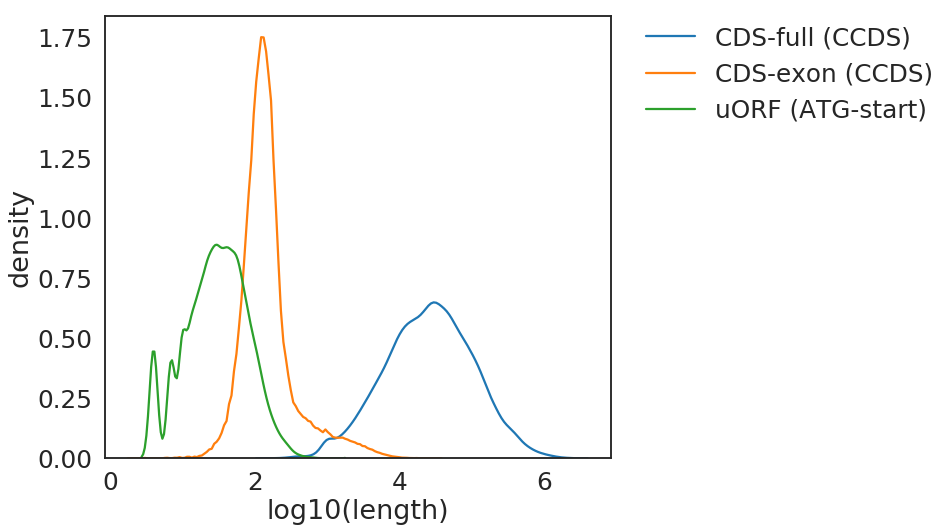

In [158]:
nonzero_lengths = [x for x in candidate_orf_lengths if x!=0]
sns.set_context('talk', font_scale=1.5)
fig, ax = plt.subplots(figsize=(14,8))
#sns.distplot(np.log10(nonzero_lengths), ax=ax, hist=False)
#sns.distplot(np.log10(1+np.array(candidate_orf_lengths)), ax=ax, hist=False)
sns.distplot(np.log10(1+df_cds['length'].values), ax=ax, hist=False, label='CDS-full (CCDS)')
sns.distplot(np.log10(1+np.array(ccds_exons_lengths)), ax=ax, hist=False, label='CDS-exon (CCDS)')
sns.distplot(np.log10(1+np.array(nonzero_lengths)), ax=ax, hist=False, label='uORF (ATG-start)')
#ax.legend(frameon=False, loc=7)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)

ax.set_xlabel('log10(length)')
ax.set_ylabel('density')
fig.tight_layout()
fig.savefig('uORF_length_dist.pdf', transparent=True)
fig.savefig('uORF_length_dist.svg', transparent=True)

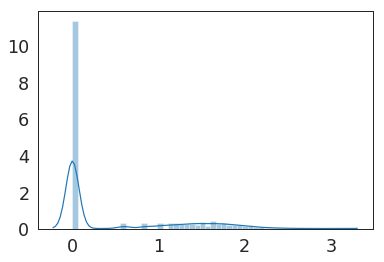

In [127]:
sns.distplot()

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/seaborn/distributions.py:39: RuntimeWarning: invalid value encountered in double_scalars
  return int(np.ceil((a.max() - a.min()) / h))


ValueError: cannot convert float NaN to integer

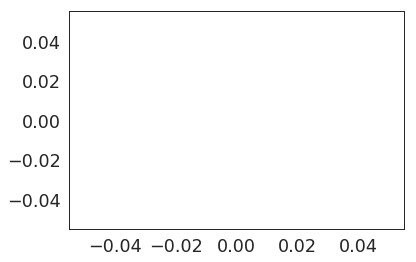

In [123]:
sns.distplot(np.log10(candidate_orf_lengths))

In [26]:
seq = 'ATTGATTGTTGTG'
start_codon_matches, start_codon_matches_dict = find_matches(seq, START_CODONS)
start_codon_matches

OrderedDict([(0, 'ATT'),
             (1, 'TTG'),
             (4, 'ATT'),
             (5, 'TTG'),
             (8, 'TTG'),
             (10, 'GTG')])

In [27]:
start_codon_matches_dict

defaultdict(list, {'ATT': [0, 4], 'TTG': [1, 5, 8], 'GTG': [10]})

In [29]:
sequence = fasta_reader.query(intervals=[Interval('chr7', 127588345, 127588498)]) [0]
start_codon_matches, start_codon_matches_dict = find_matches(sequence, START_CODONS)
start_codon_matches

OrderedDict([(0, 'ACG'),
             (17, 'GTG'),
             (20, 'ACG'),
             (28, 'AGG'),
             (37, 'ACG'),
             (45, 'AGG'),
             (66, 'CTG'),
             (69, 'CTG'),
             (72, 'CTG'),
             (75, 'CTG'),
             (84, 'ATC'),
             (126, 'GTG')])

In [35]:
stop_codon_matches_dict

defaultdict(list,
            {'TAA': [21, 44, 95, 115, 166, 183, 205, 284, 305, 334, 338, 374],
             'TAG': [27, 61, 65, 155, 252],
             'TGA': [52, 89, 104, 142, 186, 243, 268, 296, 348, 391, 440]})

In [34]:
stop_codon_matches, stop_codon_matches_dict = find_matches(sequence, STOP_CODONS)
stop_codon_matches


OrderedDict([(21, 'TAA'),
             (27, 'TAG'),
             (44, 'TAA'),
             (52, 'TGA'),
             (61, 'TAG'),
             (65, 'TAG'),
             (89, 'TGA'),
             (95, 'TAA'),
             (104, 'TGA'),
             (115, 'TAA'),
             (142, 'TGA'),
             (155, 'TAG'),
             (166, 'TAA'),
             (183, 'TAA'),
             (186, 'TGA'),
             (205, 'TAA'),
             (243, 'TGA'),
             (252, 'TAG'),
             (268, 'TGA'),
             (284, 'TAA'),
             (296, 'TGA'),
             (305, 'TAA'),
             (334, 'TAA'),
             (338, 'TAA'),
             (348, 'TGA'),
             (374, 'TAA'),
             (391, 'TGA'),
             (440, 'TGA')])

In [53]:
START_CODONS

['ATG', 'AAG', 'ACG', 'ATC', 'GTG', 'AGG', 'ATA', 'ATT', 'CTG', 'TTG']

In [52]:
df

,start_index,stop_index,start_codon,stop_codon,length
224,5,44,ATT,TAA,39
225,5,65,ATT,TAG,60
226,5,89,ATT,TGA,84
227,5,95,ATT,TAA,90
228,5,104,ATT,TGA,99
229,5,155,ATT,TAG,150
230,5,284,ATT,TAA,279
231,5,296,ATT,TGA,291
232,5,305,ATT,TAA,300
233,5,338,ATT,TAA,333


In [94]:
df[df.start_codon=='ATG']

,start_index,stop_index,start_codon,stop_codon,length
6,51,183,ATG,TAA,132
7,51,186,ATG,TGA,135
8,51,243,ATG,TGA,192
9,51,252,ATG,TAG,201
10,51,348,ATG,TGA,297
306,98,104,ATG,TGA,6
307,98,155,ATG,TAG,57
308,98,284,ATG,TAA,186
309,98,296,ATG,TGA,198
310,98,305,ATG,TAA,207


In [71]:
df[df.start_codon=='CTG']

,start_index,stop_index,start_codon,stop_codon,length
31,132,183,CTG,TAA,51
32,132,186,CTG,TGA,54
33,132,243,CTG,TGA,111
34,132,252,CTG,TAG,120
35,132,348,CTG,TGA,216
51,159,183,CTG,TAA,24
52,159,186,CTG,TGA,27
53,159,243,CTG,TGA,84
54,159,252,CTG,TAG,93
55,159,348,CTG,TGA,189


In [54]:
df[df.start_codon=='ATG']

,start_index,stop_index,start_codon,stop_codon,length
6,51,183,ATG,TAA,132
7,51,186,ATG,TGA,135
8,51,243,ATG,TGA,192
9,51,252,ATG,TAG,201
10,51,348,ATG,TGA,297
306,98,104,ATG,TGA,6
307,98,155,ATG,TAG,57
308,98,284,ATG,TAA,186
309,98,296,ATG,TGA,198
310,98,305,ATG,TAA,207


In [69]:
127588345 + 51

127588396

In [72]:
utr5_df.shape

(103583, 11)

In [74]:
len(utr5_df.transcript_id.unique())

65246

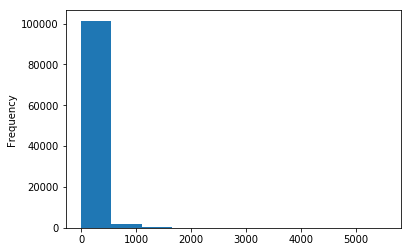

In [77]:
utr5_df['length'] = utr5_df['end'] - utr5_df['start']
utr5_df['length'].plot(kind='hist')

In [78]:
utr5_df['length'].describe()

count    103583.000000
mean        130.507979
std         168.764188
min           0.000000
25%          40.000000
50%          87.000000
75%         161.000000
max        5544.000000
Name: length, dtype: float64

In [ ]:
#ENST00000000233.9	ENSG00000004059.10	protein_coding	chr7	127588345	127588498	+


In [70]:
eif1_df.head()

,transcript_stable_ID,gene_stable_ID,uORF.CDS.pair_ID,position.aTIS,position.uTIS,start_codon_aTIS,start_codon_uTIS,strand,uORF_length_nt,uTIS.AUG.or.non_AUG,uTIS.class,uTIS_Kozak,uTIS_dist_to_aTIS_nt,LFQ.si.Ctrl.rep1,LFQ.si.Ctrl.rep2
uTIS.ID,,,,,,,,,,,,,,,
ENST00000000233_127588411,ENST00000000233,ENSG00000004059,ENST00000000233_127588499_127588411,127588499,127588411.0,ATG,CTG,1,264.0,non-AUG,u-oORF,weak,-88.0,29.64103,29.75042
ENST00000000412_8949529,ENST00000000412,ENSG00000003056,ENST00000000412_8946404_8949529,8946404,8949529.0,ATG,CTG,-1,162.0,non-AUG,u-oORF,weak,-43.0,26.05631,26.00443
ENST00000000412_8949563,ENST00000000412,ENSG00000003056,ENST00000000412_8946404_8949563,8946404,8949563.0,ATG,CTG,-1,141.0,non-AUG,u-oORF,weak,-77.0,26.05631,26.00443
ENST00000000412_8949593,ENST00000000412,ENSG00000003056,ENST00000000412_8946404_8949593,8946404,8949593.0,ATG,CTG,-1,30.0,non-AUG,uORF,strong,-107.0,26.05631,26.00443
ENST00000000412_8949612,ENST00000000412,ENSG00000003056,ENST00000000412_8946404_8949612,8946404,8949612.0,ATG,CTG,-1,96.0,non-AUG,uORF,strong,-126.0,26.05631,26.00443


In [84]:
# first row that is on positive strand
# ENST00000000233.9	ENSG00000004059.10	protein_coding	chr7	127588345	127588498	+	1	CCDS,appris_principal_1,basic	1	NaN
fasta_reader.query(intervals=[Interval('chr7', 127588498+1, 127588498+3)]) 



['ATG']

In [89]:
127588373
fasta_reader.query(intervals=[Interval('chr7', 127588373, 127588373+2)]) 


['AGG']

In [85]:
# second row that is on negative strand
# ENST00000000412.7	ENSG00000003056.7	protein_coding	chr12	8946405	8946405	-	2	CCDS,appris_principal_1,basic	1	NaN
fasta_reader.reverse_complement(fasta_reader.query(intervals=[Interval('chr12', 8946405-3, 8946405-1)])[0] )



'ATG'

# Select a row thats labeleed upstream_uORF and find out why is it so?


In [87]:
df_uORF = df[df.uORF_type=='upstream_uORF']
df_uORF

,index,transcript_id,gene_id,gene_type,chrom,start,end,strand,exon_number,tags,is_CCDS,uORF_type
404,103532,ENST00000199448.8,ENSG00000086289.11,protein_coding,chr7,37920561,37920939,+,1,"CCDS,appris_principal_3,basic,upstream_uORF",1,upstream_uORF
2329,7442,ENST00000245121.9,ENSG00000167216.16,protein_coding,chr18,46946824,46946872,+,1,"CCDS,appris_principal_2,basic,upstream_uORF",1,upstream_uORF
3910,57773,ENST00000261192.11,ENSG00000060982.14,protein_coding,chr12,24948933,24949459,-,1,"CCDS,appris_principal_3,basic,upstream_uORF",1,upstream_uORF
5800,103562,ENST00000270538.7,ENSG00000104980.7,protein_coding,chr19,7943652,7943920,-,1,"CCDS,appris_principal_1,basic,upstream_uORF",1,upstream_uORF
9427,18451,ENST00000303212.2,ENSG00000171119.2,protein_coding,chr19,5823802,5824165,+,1,"CCDS,appris_principal_1,basic,upstream_uORF",1,upstream_uORF
12513,97986,ENST00000321702.2,ENSG00000177191.2,protein_coding,chr19,41426779,41426810,-,3,"CCDS,appris_principal_1,basic,upstream_uORF",1,upstream_uORF
12514,97987,ENST00000321702.2,ENSG00000177191.2,protein_coding,chr19,41427284,41427570,-,2,"CCDS,appris_principal_1,basic,upstream_uORF",1,upstream_uORF
12515,97988,ENST00000321702.2,ENSG00000177191.2,protein_coding,chr19,41428596,41428730,-,1,"CCDS,appris_principal_1,basic,upstream_uORF",1,upstream_uORF
12626,14423,ENST00000322354.3,ENSG00000167565.12,protein_coding,chr19,40442081,40442086,-,2,"CCDS,appris_principal_2,basic,upstream_uORF",1,upstream_uORF
12627,14429,ENST00000322354.3,ENSG00000167565.12,protein_coding,chr19,40444215,40444705,-,1,"CCDS,appris_principal_2,basic,upstream_uORF",1,upstream_uORF


In [88]:
#103532	ENST00000199448.8	ENSG00000086289.11	protein_coding	chr7	37920561	37920939	+	1	CCDS,appris_principal_3,basic,upstream_uORF	1	upstream_uORF
sequence = fasta_reader.query([Interval('chr7', 37920561, 37920939)])
sequence

['TCCCCCCTCTTAAAACACGATGCCTCCCAGGATGCTAGTGGCACCACTGCCACTGCATTTCCTGTTGGCAGCAGTGAGCAGTGAAAACCGAAGCGGCAGAAGGCAGTGGCAGCAGGCAGTGGCAGCAGGCAGTGGCCCAGGCAGAAATAGCTCCCGCGCGATTCACTGGAGCCTTCCCCGGGCCCTGGTCCCGGCTACCGGGACTCGCGCGTCCGGATCTCAAAAGCGGCAGAGGCCACCGAAGGGACAGGAAGCACTTTGGTCCAGACCACACTCCCGGCACAGTGCGGAAAGAGCCGGCGGGAGCCACTCTGATCCCGGACGCCTCAGCGCCCCCTTGGGCTTGGGCTTGCCCTCGGGCCGGGGAAGGCTGACCGCG']

In [57]:
df.head()

,start_index,stop_index,start_codon,stop_codon,length
224,5,44,ATT,TAA,39
225,5,65,ATT,TAG,60
226,5,89,ATT,TGA,84
227,5,95,ATT,TAA,90
228,5,104,ATT,TGA,99


In [56]:
eif1_df = pd.read_table('/home/cmb-panasas2/wenzhenl/benchmark/real/eif1_real_app_all_data.txt').sort_values(by='transcript_stable_ID')
#sorted(eif1_df.columns)
eif1_df = eif1_df[['uTIS.ID', 'transcript_stable_ID', 'gene_stable_ID', 'uORF.CDS.pair_ID', 'position.aTIS',
                   'position.uTIS', 'start_codon_aTIS', 'start_codon_uTIS', 'strand',
                   'uORF_length_nt', 'uTIS.AUG.or.non_AUG', 'uTIS.class', 'uTIS_Kozak', 'uTIS_dist_to_aTIS_nt', 'LFQ.si.Ctrl.rep1',
                   'LFQ.si.Ctrl.rep2']]
eif1_df = eif1_df[eif1_df['LFQ.si.Ctrl.rep1']>0]
eif1_df = eif1_df[eif1_df['LFQ.si.Ctrl.rep2']>0]
eif1_df = eif1_df.sort_values(by='uTIS.ID').set_index('uTIS.ID').dropna()
eif1_df.head()

,transcript_stable_ID,gene_stable_ID,uORF.CDS.pair_ID,position.aTIS,position.uTIS,start_codon_aTIS,start_codon_uTIS,strand,uORF_length_nt,uTIS.AUG.or.non_AUG,uTIS.class,uTIS_Kozak,uTIS_dist_to_aTIS_nt,LFQ.si.Ctrl.rep1,LFQ.si.Ctrl.rep2
uTIS.ID,,,,,,,,,,,,,,,
ENST00000000233_127588411,ENST00000000233,ENSG00000004059,ENST00000000233_127588499_127588411,127588499,127588411.0,ATG,CTG,1,264.0,non-AUG,u-oORF,weak,-88.0,29.64103,29.75042
ENST00000000412_8949529,ENST00000000412,ENSG00000003056,ENST00000000412_8946404_8949529,8946404,8949529.0,ATG,CTG,-1,162.0,non-AUG,u-oORF,weak,-43.0,26.05631,26.00443
ENST00000000412_8949563,ENST00000000412,ENSG00000003056,ENST00000000412_8946404_8949563,8946404,8949563.0,ATG,CTG,-1,141.0,non-AUG,u-oORF,weak,-77.0,26.05631,26.00443
ENST00000000412_8949593,ENST00000000412,ENSG00000003056,ENST00000000412_8946404_8949593,8946404,8949593.0,ATG,CTG,-1,30.0,non-AUG,uORF,strong,-107.0,26.05631,26.00443
ENST00000000412_8949612,ENST00000000412,ENSG00000003056,ENST00000000412_8946404_8949612,8946404,8949612.0,ATG,CTG,-1,96.0,non-AUG,uORF,strong,-126.0,26.05631,26.00443


In [249]:
127588411
# this is first row of the eif1_df table
fasta_reader.query(intervals=[Interval('chr7', 127588411, 127588411+2)]) 


['CTG']

In [91]:
#127588390
#	39280	ENST00000000233.9	ENSG00000004059.10	protein_coding	chr7	127588345	127588498	+	1	CCDS,appris_principal_1,basic	1	NaN
fasta_reader.query(intervals=[Interval('chr7', 127588390, 127588390+2)]) 


['AGG']

In [293]:
# ENST00000000412_8949529	ENST00000000412	ENSG00000003056	ENST00000000412_8946404_8949529	8946404	8949529.0	ATG	CTG	-1	162.0	non-AUG	u-oORF	w
#8949529.0	
##************************
fasta_reader.reverse_complement(fasta_reader.query(intervals=[Interval('chr12', 8949529-2, 8949529)])[0] )


'CTG'

In [ ]:
re.finditer('')

In [94]:
#103532	ENST00000199448.8	ENSG00000086289.11	protein_coding	chr7	37920561	37920939	+	1	CCDS,appris_principal_3,basic,upstream_uORF	1	upstream_uORF
sequence = fasta_reader.query([Interval('chr7', 37920561, 37920939)])
sequence

['TCCCCCCTCTTAAAACACGATGCCTCCCAGGATGCTAGTGGCACCACTGCCACTGCATTTCCTGTTGGCAGCAGTGAGCAGTGAAAACCGAAGCGGCAGAAGGCAGTGGCAGCAGGCAGTGGCAGCAGGCAGTGGCCCAGGCAGAAATAGCTCCCGCGCGATTCACTGGAGCCTTCCCCGGGCCCTGGTCCCGGCTACCGGGACTCGCGCGTCCGGATCTCAAAAGCGGCAGAGGCCACCGAAGGGACAGGAAGCACTTTGGTCCAGACCACACTCCCGGCACAGTGCGGAAAGAGCCGGCGGGAGCCACTCTGATCCCGGACGCCTCAGCGCCCCCTTGGGCTTGGGCTTGCCCTCGGGCCGGGGAAGGCTGACCGCG']

In [ ]:
matches = [match.start(0), ]

In [102]:
matches = re.finditer(re.compile('|'.join(START_CODONS)) , sequence[0])
results = [int(match.group(0)) for match in matches]


ValueError: invalid literal for int() with base 10: 'ACG'

In [99]:
'|'.join(START_CODONS)

'ATG|AAG|ACG|ATC|GTG|AGG|ATA|ATT|CTG|TTG'

In [105]:
for match in matches:
    print(match.groups)
    break

<built-in method groups of _sre.SRE_Match object at 0x2b3e482947e8>


In [109]:
match.pos

0

In [110]:
sequence

['TCCCCCCTCTTAAAACACGATGCCTCCCAGGATGCTAGTGGCACCACTGCCACTGCATTTCCTGTTGGCAGCAGTGAGCAGTGAAAACCGAAGCGGCAGAAGGCAGTGGCAGCAGGCAGTGGCAGCAGGCAGTGGCCCAGGCAGAAATAGCTCCCGCGCGATTCACTGGAGCCTTCCCCGGGCCCTGGTCCCGGCTACCGGGACTCGCGCGTCCGGATCTCAAAAGCGGCAGAGGCCACCGAAGGGACAGGAAGCACTTTGGTCCAGACCACACTCCCGGCACAGTGCGGAAAGAGCCGGCGGGAGCCACTCTGATCCCGGACGCCTCAGCGCCCCCTTGGGCTTGGGCTTGCCCTCGGGCCGGGGAAGGCTGACCGCG']

In [111]:
seq = ''.join(START_CODONS)

In [122]:
seq

'ATGAAGACGATCGTGAGGATAATTCTGTTG'

In [126]:
START_CODONS

['ATG', 'AAG', 'ACG', 'ATC', 'GTG', 'AGG', 'ATA', 'ATT', 'CTG', 'TTG']

In [124]:
seq = 'ATGATGATGATCGTGAGGATAATTCTGTTG'

In [135]:
seq = 'ATTG'

In [147]:
matches = re.finditer(r"(?=({}))".format('|'.join(START_CODONS)) , seq)
#'ATTG'
#matches = re.finditer(r"(?=(ATT|TTG))", seq)
for match in matches:
    print (match.start(0), match.group(1))

 0 ATT
 1 TTG


In [148]:
seq = 'ATTGATTGTTGTG'

In [150]:
seq = 'ATTGATTGTTGTG'
matches = re.finditer(r"(?=({}))".format('|'.join(START_CODONS)) , seq)
#'ATTG'
#matches = re.finditer(r"(?=(ATT|TTG))", seq)
for match in matches:
    print (1+match.start(0), match.group(1))

1 ATT
2 TTG
5 ATT
6 TTG
9 TTG
11 GTG


In [152]:
seq = 'ATTGATTGTTGTG'
matches = re.finditer(re.compile('|'.join(START_CODONS)) , seq)
#'ATTG'
#matches = re.finditer(r"(?=(ATT|TTG))", seq)
for match in matches:
    print (match.start(0), match.group(0))

0 ATT
4 ATT
8 TTG
